In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import seaborn as sns

from weatherbench2.metrics import MAE

In [5]:
import graphufs
from p1stacked import P1Emulator

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [6]:
plt.style.use("graphufs.plotstyle")

In [7]:
p1 = P1Emulator()

In [8]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [9]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [10]:
ds = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic.nc")
tds = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic_temporal.nc")
sds = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic_spatial.nc")

In [11]:
def plot_surface_metrics(
    error_list,
    metric="mae",
    fields=("2m_temperature", "surface_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind"),
):

    ncols = len(fields)
    fig, axs = plt.subplots(1, ncols, figsize=(ncols*3, 4), constrained_layout=True)

    for i, (fld, ax) in enumerate(zip(fields, axs)):

        for j, xds in enumerate(error_list):
            kw = {
                "ax": ax,
                "color": f"C{j}",
            }
            if fld in xds:
                plotme = xds[fld].sel(metric=metric)
                if "init_time" in plotme.dims:
                    plotme = plotme.mean("init_time")
                plotme.plot(label=xds.label if i == 0 else None, **kw)
    
        title = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
        xticks = xds.fhr.values[3::4]
        ylim = [0, None] if metric == "mae" else [None, None]
        ax.set(
            xlabel="Lead time (days)",
            ylabel="",
            title=title,
            xticks=xticks,
            xticklabels=[x//24 for x in xticks],
            ylim=ylim,
        )
    
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))
    fig.suptitle(f"{metric.upper()} vs Replay")
    return fig, axs

In [46]:
tds3 = tds.where(tds.init_time.dt.hour // 6 != tds.init_time.dt.hour / 6, drop=True)
tds6 = tds.where(tds.init_time.dt.hour // 6 == tds.init_time.dt.hour / 6, drop=True)

In [105]:
tds3.attrs["label"] = "Same window\nt0 in (03z, 09z, 15z, 21z)"
tds6.attrs["label"] = "Different windows\nt0 in (00z, 06z, 12z, 18z)"

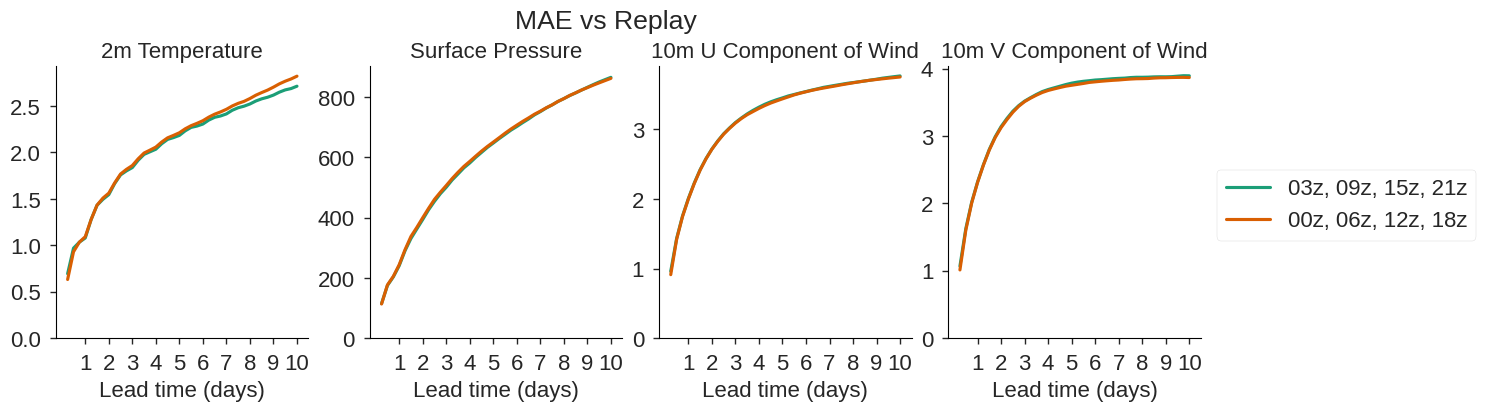

In [48]:
#fig, axs = plot_surface_metrics(list(maeh.values()))
fig, axs = plot_surface_metrics([tds3, tds6])

## 3D Variables

In [116]:
def plot_level_metrics(
    error_list,
    metric="mae",
    fields=("temperature", "specific_humidity", "u_component_of_wind", "v_component_of_wind"),
    levels=[100, 500, 750, 1000], 
    xlim=[None, None],
    add_inset=False,
):

    nrows = len(levels)
    ncols = len(fields)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), constrained_layout=True, sharex=True)

    for i, (fld, axc) in enumerate(zip(fields, axs.T)):

        for level, ax in zip(levels, axc):
            for j, xds in enumerate(error_list):
                kw = {
                    "ax": ax,
                    "color": f"C{j}",
                    "label": xds.label if i == 0 and level == levels[0] else None,
                }
                if fld in xds:
                    plotme = xds[fld].sel(metric=metric)
                    plotme = plotme.sel(level=level, method="nearest")
                    sns.lineplot(
                        data=plotme.to_dataframe().reset_index(),
                        x="fhr",
                        y=fld,
                        legend=False,
                        **kw,
                    )

                    # inset zoomed in to first 24 hours
                    if add_inset:
                        axins = ax.inset_axes(
                            [0.5, 0.1, 0.5, 0.5],
                            xlim=(plotme.fhr.values[0], 24),
                            ylim=(plotme.sel(fhr=6).min().values*.95, plotme.sel(fhr=24).max().values*1.05),
                            xticklabels=[],
                            yticklabels=[],
                        )
                        sns.lineplot(
                            data=plotme.to_dataframe().reset_index(),
                            x="fhr",
                            y=fld,
                            legend=False,
                            label=None,
                            ax=axins,
                            color=f"C{j}",
                        )
                        ax.indicate_inset_zoom(axins, edgecolor="black")
                        axins.set(
                            ylabel="",
                            xlabel="",
                        )
                        
                
            title = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
            xticks = [0] + [x for x in xds.fhr.values[3::4]]
            ylim = [0, None] if metric == "mae" else [None, None]
            if xlim[-1] is not None:
                ylim[-1] = plotme.sel(fhr=slice(xlim[-1]+1)).max().values*1.05
            sps = ax.get_subplotspec()
            ax.set(
                xlabel="Lead time (days)" if sps.is_last_row() else "",
                ylabel=f"~{int(plotme.level.values)} hPa",
                title=title if sps.is_first_row() else "",
                xticks=xticks,
                xticklabels=[x//24 for x in xticks],
                ylim=ylim,
                xlim=xlim,
            )
            for key in ["right", "top"]:
                ax.spines[key].set_visible(False)
    
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))
    fig.suptitle(f"{metric.upper()} vs Replay")
    return fig, axs

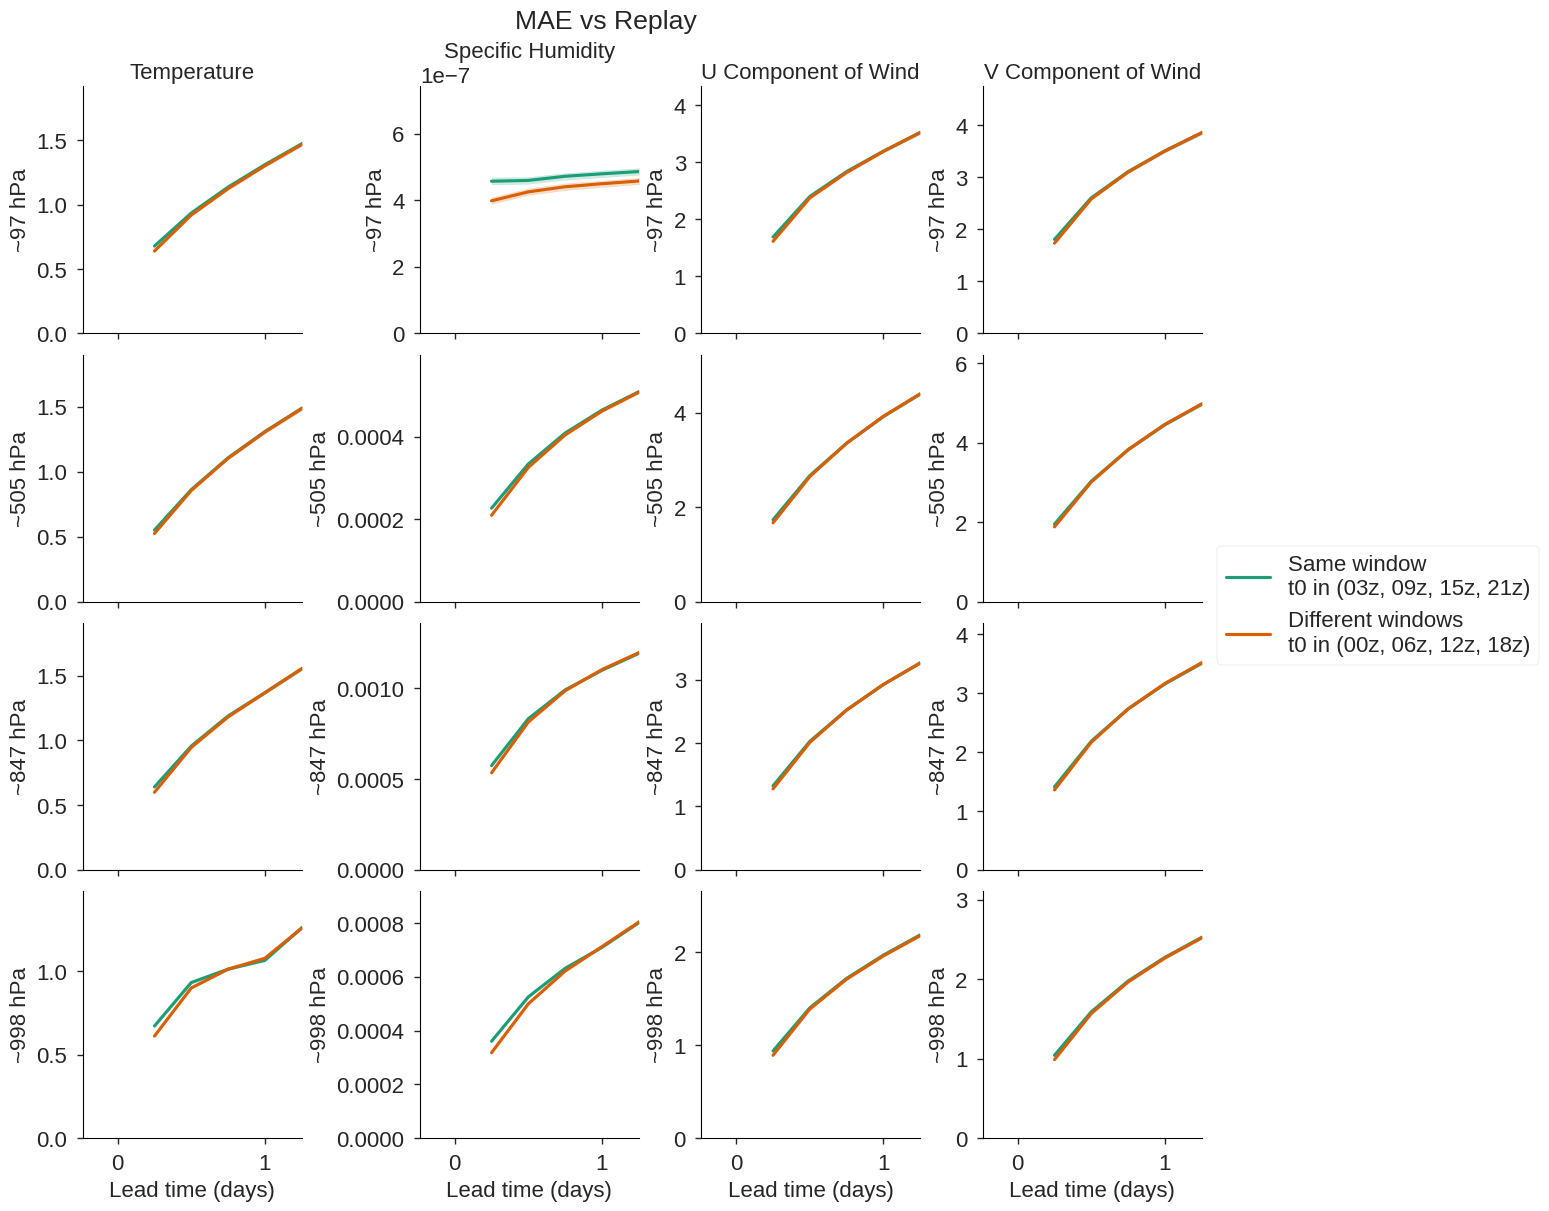

In [117]:
fig, axs = plot_level_metrics([tds3, tds6], xlim=[None, 30])
fig.savefig(f"figures/mae_vs_replay_ictest_zoom.jpeg", bbox_inches="tight", dpi=300)

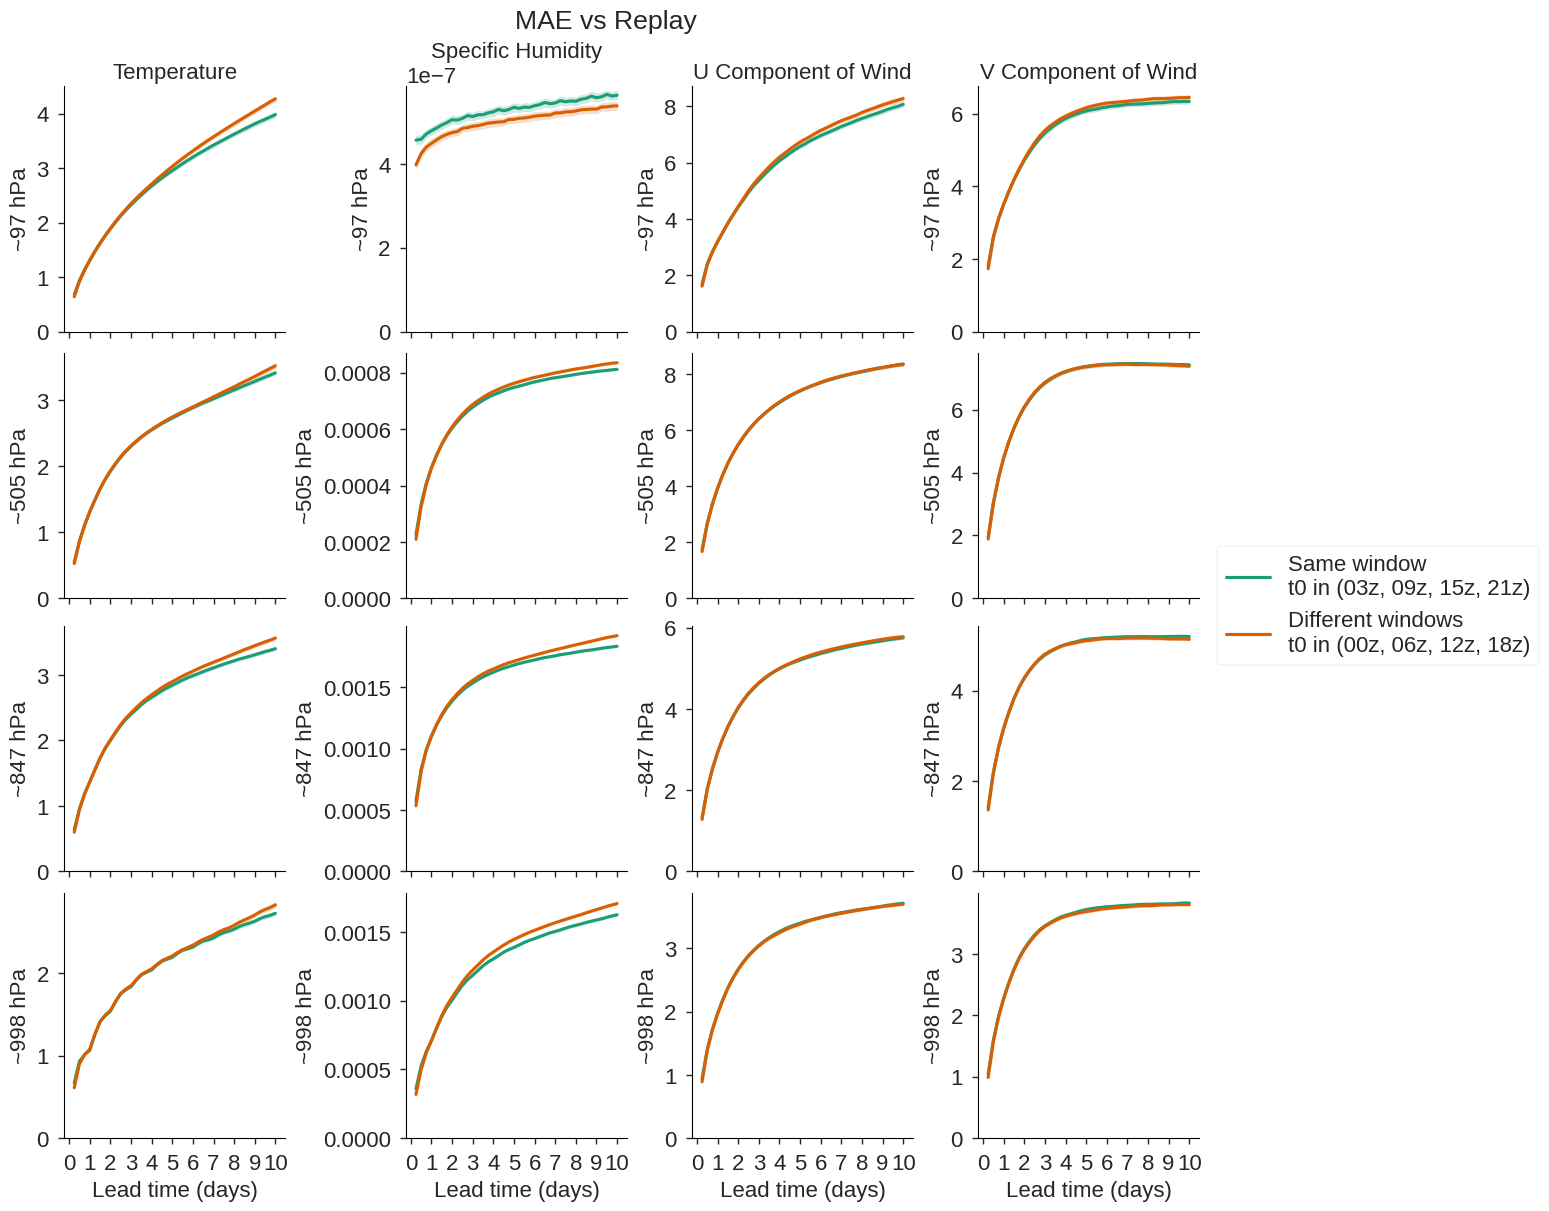

In [118]:
fig, axs = plot_level_metrics([tds3, tds6])
fig.savefig(f"figures/mae_vs_replay_ictest.jpeg", bbox_inches="tight", dpi=300)